In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import math
import numpy as np
import torch
from torch.nn import functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import is_undirected, to_undirected, remove_self_loops, to_dense_adj, dense_to_sparse
import e3nn
from e3nn import o3
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from src.utils.plot_utils import plot_2d, plot_3d
from src.utils.train_utils import run_experiment
from src.models import MPNNModel, EGNNModel, GVPGNNModel, TFNModel, SchNetModel, DimeNetPPModel, MACEModel

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

PyTorch version 1.12.1
PyG version 2.1.0
e3nn version 0.4.4
Using device: cpu


In [2]:
def create_rotsym_envs(fold=3):
    dataset = []

    # Environment 0
    atoms = torch.LongTensor([ 0 ] + [ 0 ] * fold)
    edge_index = torch.LongTensor( [ [0] * fold, [i for i in range(1, fold+1)] ] )
    x = torch.Tensor([1,0,0])
    pos = [
        torch.Tensor([0,0,0]),  # origin
        x,   # first spoke 
    ]
    for count in range(1, fold):
        R = o3.matrix_z(torch.Tensor([2*math.pi/fold * count])).squeeze(0)
        pos.append(x @ R.T)
    pos = torch.stack(pos)
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    q = 2*math.pi/(fold + random.randint(1, fold))
    assert q < 2*math.pi/fold
    Q = o3.matrix_z(torch.Tensor([q])).squeeze(0)
    pos = pos @ Q.T
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

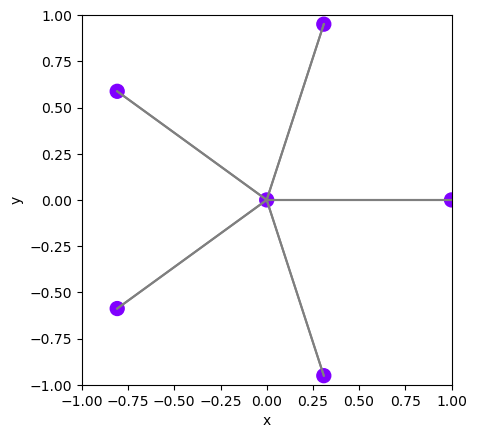

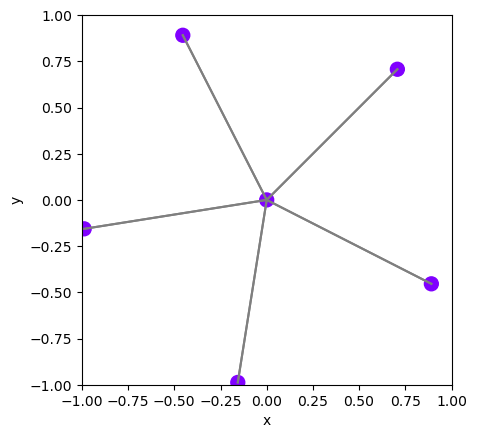

Running experiment for TFNModel (cpu).


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.80s/it]


Done! Averaged over 10 runs: 
 - Training time: 12.78s ± 0.86. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



In [3]:
# Set parameters
model_name = "tfn"# here we can change the model label and run different models
correlation = 2
max_ell = 3
fold = 5

# Create dataset
dataset = create_rotsym_envs(fold)
for data in dataset:
    plot_2d(data, lim=1)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

num_layers = 1
model = {
    "mpnn": MPNNModel,
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": partial(TFNModel, max_ell=max_ell, scalar_pred=False),
    "mace": partial(MACEModel, max_ell=max_ell, correlation=correlation, scalar_pred=False),
}[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)